In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, butter
from sklearn.preprocessing import MinMaxScaler

In [61]:
data = pd.read_csv("../data/OpenBCI-RAW-2024-09-04_17-56-48.csv", skiprows=4)
data.columns = data.columns.str.strip()

In [62]:
label = 'resting' # Label Sinyal Saat Ini
start_from_minutes = 1 # Dimulai Dari Menit
start_from_seconds = 23 # Dimulai Dari Detik
end_from_minutes = 3 # Selesai Pada Menit
end_from_seconds = 21 # Selesai Pada Detik

In [63]:
window_size = 250  # Ukuran window (contoh: 1 detik dengan sampling rate 250 Hz)
step_size = 125    # Overlap 50%

# Fungsi untuk windowing
def apply_windowing(data, window_size, step_size):
    windows = []
    for start in range(0, len(data) - window_size, step_size):
        window = data[start:start + window_size]
        windows.append(window)
    return np.array(windows)

In [64]:
fs = 250  # Sampling rate (contoh: 250 Hz)
f0 = 50   # Frekuensi yang ingin dihilangkan (contoh: 50 Hz)
quality_factor = 30

def apply_notch_filter(data, f0, fs, quality_factor):
    # Hitung frekuensi normalisasi
    nyquist = 0.5 * fs
    freq = f0 / nyquist
    
    # Buat filter notch
    b, a = iirnotch(freq, quality_factor)
    
    # Terapkan filter
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [65]:
lowcut = 0.5  # Frekuensi cutoff rendah (contoh: 0.5 Hz)
highcut = 40  # Frekuensi cutoff tinggi (contoh: 40 Hz)

# Fungsi untuk menerapkan bandpass filter
def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    # Hitung frekuensi normalisasi
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Buat filter bandpass
    b, a = butter(order, [low, high], btype='band')
    
    # Terapkan filter
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [66]:
windows_per_channel = {}  # Dictionary untuk menyimpan window dari setiap channel
normalized_windows_per_channel = {}  # Dictionary untuk menyimpan window yang sudah dinormalisasi
filtered_windows_per_channel = {}  # Dictionary untuk menyimpan window yang sudah difilter

for channel in data.columns[1:9]:  # Kolom 1 hingga 8 adalah EXG Channel 0 hingga 7
    # Ambil data channel
    channel_data = data[channel].values
    
    # Terapkan windowing
    windows = apply_windowing(channel_data, window_size, step_size)
    windows_per_channel[channel] = windows
    
    # Normalisasi setiap window
    normalized_windows = []
    for window in windows:
        scaler = MinMaxScaler(feature_range=(-1, 1))  # Normalisasi ke rentang [-1, 1]
        normalized_window = scaler.fit_transform(window.reshape(-1, 1)).flatten()
        normalized_windows.append(normalized_window)
    normalized_windows_per_channel[channel] = np.array(normalized_windows)
    
    # Terapkan notch filter dan bandpass filter pada setiap window yang sudah dinormalisasi
    filtered_windows = []
    for window in normalized_windows:
        # Notch filter
        notch_filtered_window = apply_notch_filter(window, f0, fs, quality_factor)
        # Bandpass filter
        bandpass_filtered_window = apply_bandpass_filter(notch_filtered_window, lowcut, highcut, fs)
        filtered_windows.append(bandpass_filtered_window)
    filtered_windows_per_channel[channel] = np.array(filtered_windows)
    
    # Cetak jumlah window untuk channel ini
    print(f"Jumlah window untuk {channel}: {len(windows)}")

Jumlah window untuk EXG Channel 0: 276
Jumlah window untuk EXG Channel 1: 276
Jumlah window untuk EXG Channel 2: 276
Jumlah window untuk EXG Channel 3: 276
Jumlah window untuk EXG Channel 4: 276
Jumlah window untuk EXG Channel 5: 276
Jumlah window untuk EXG Channel 6: 276
Jumlah window untuk EXG Channel 7: 276


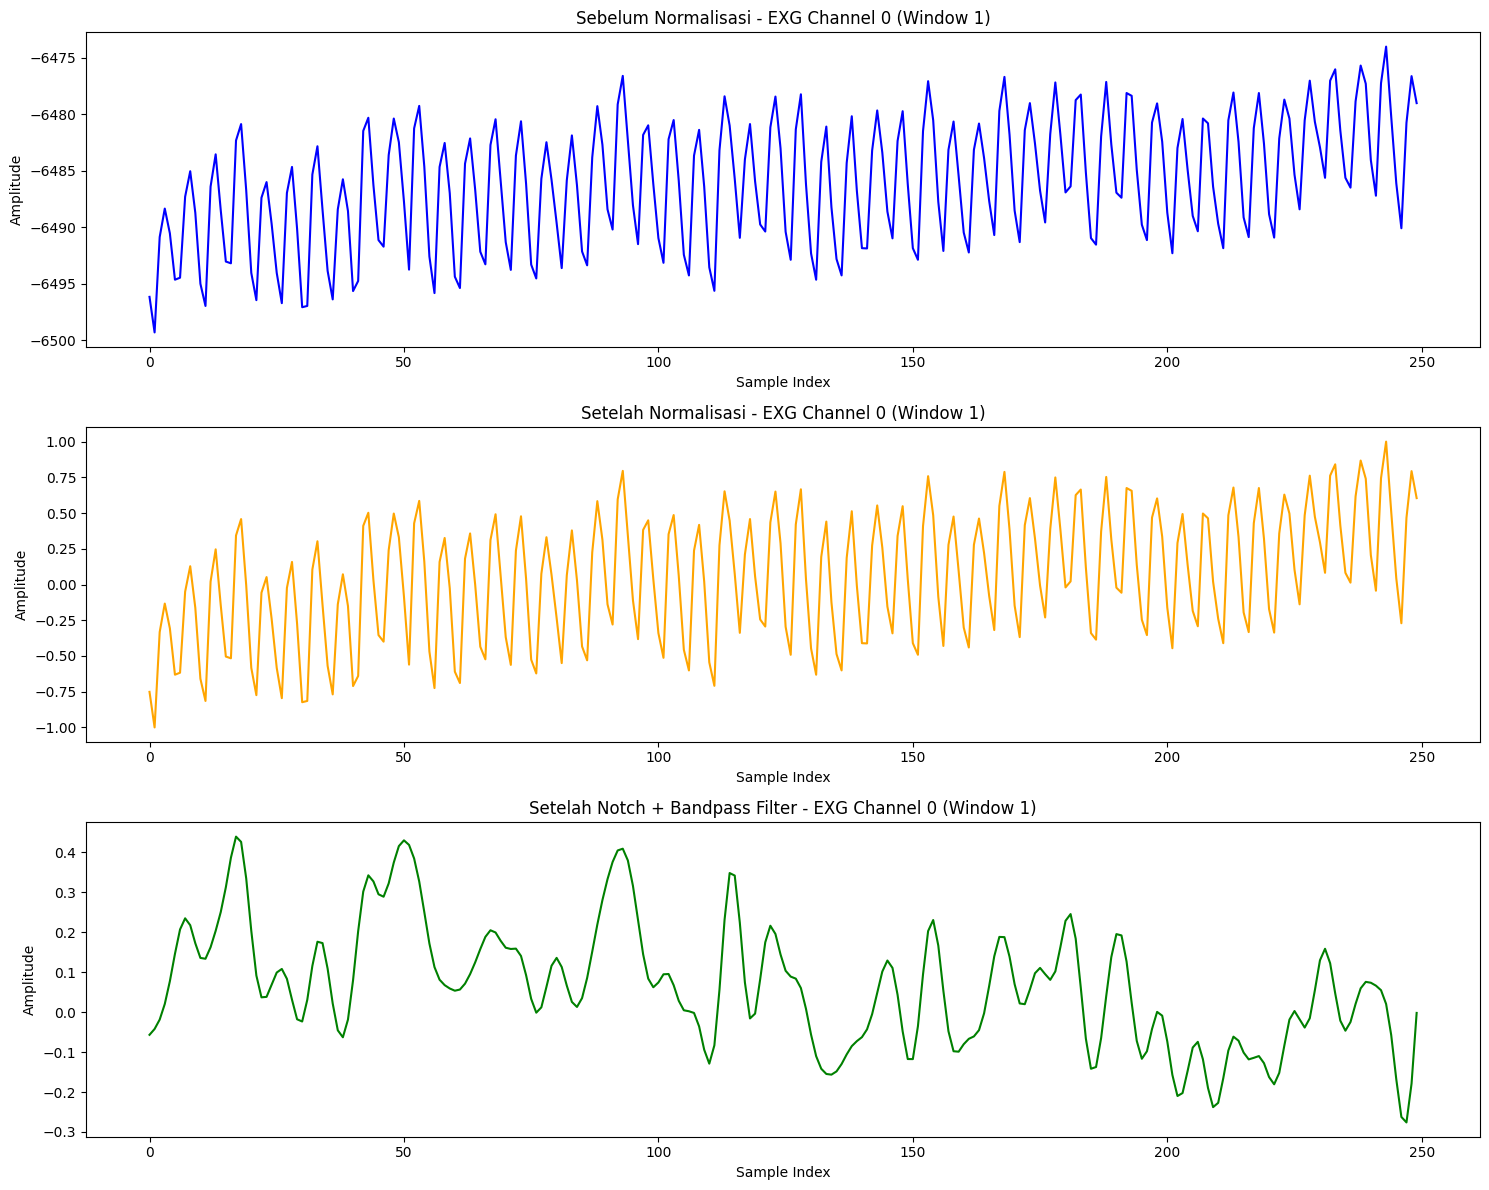

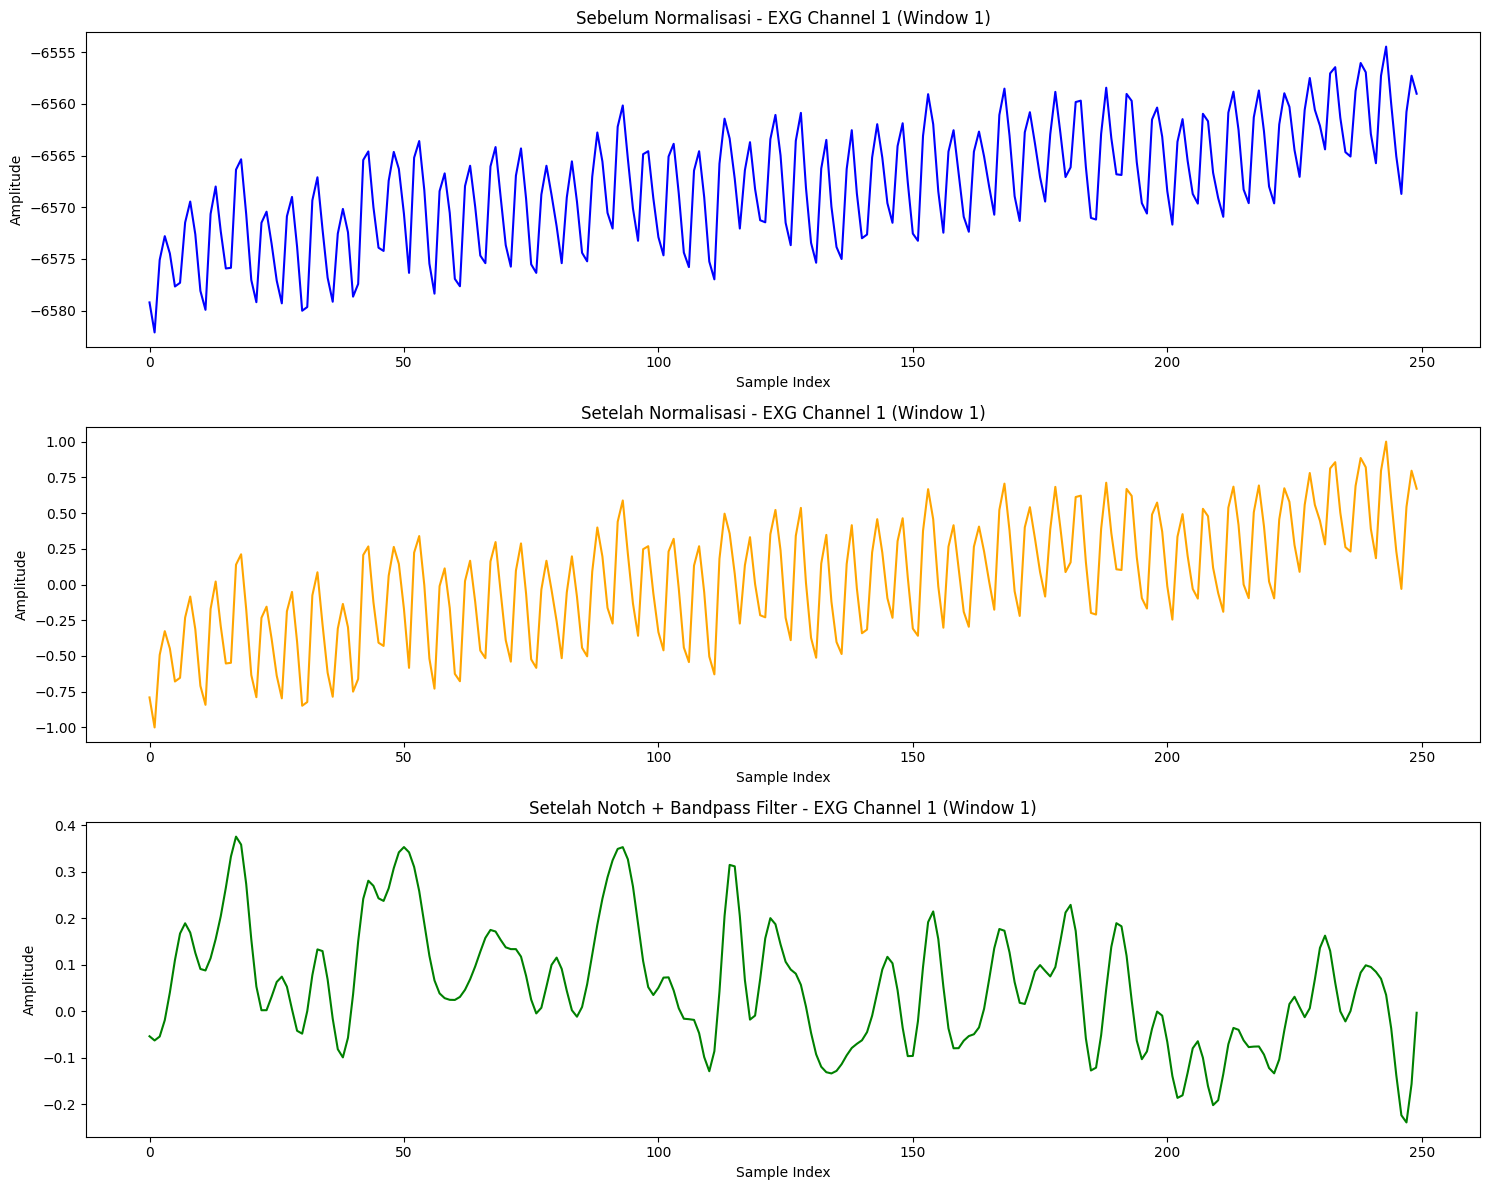

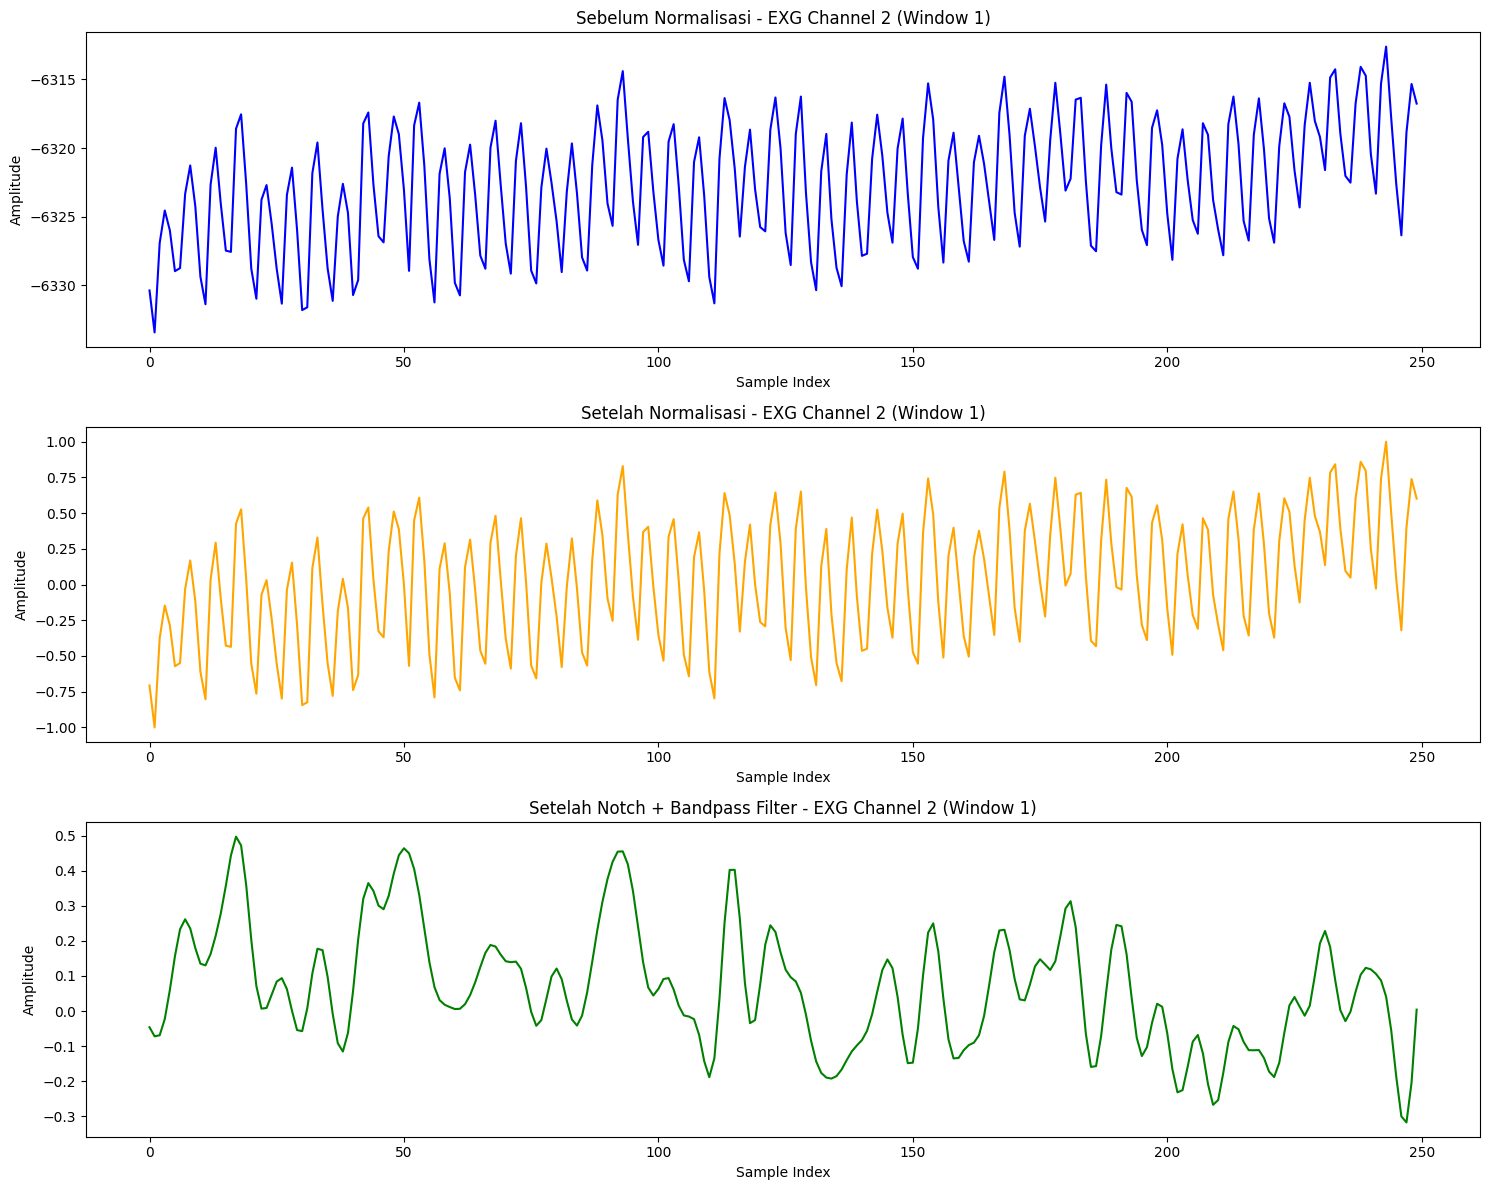

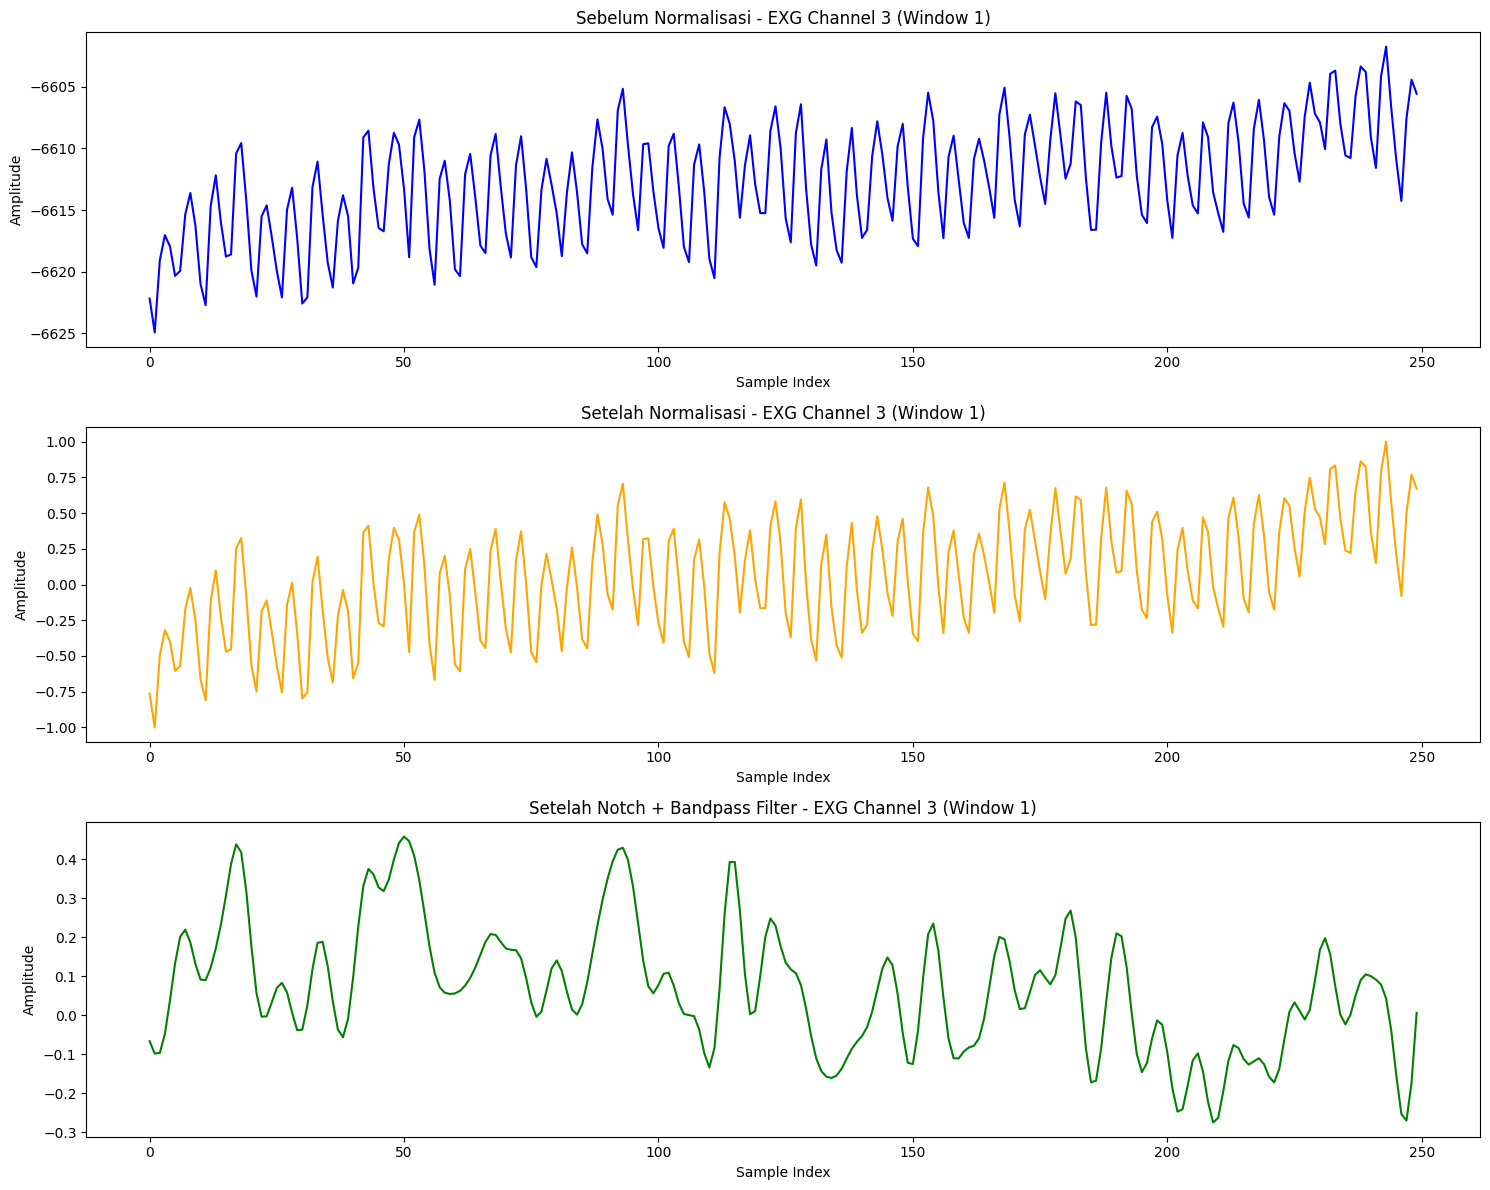

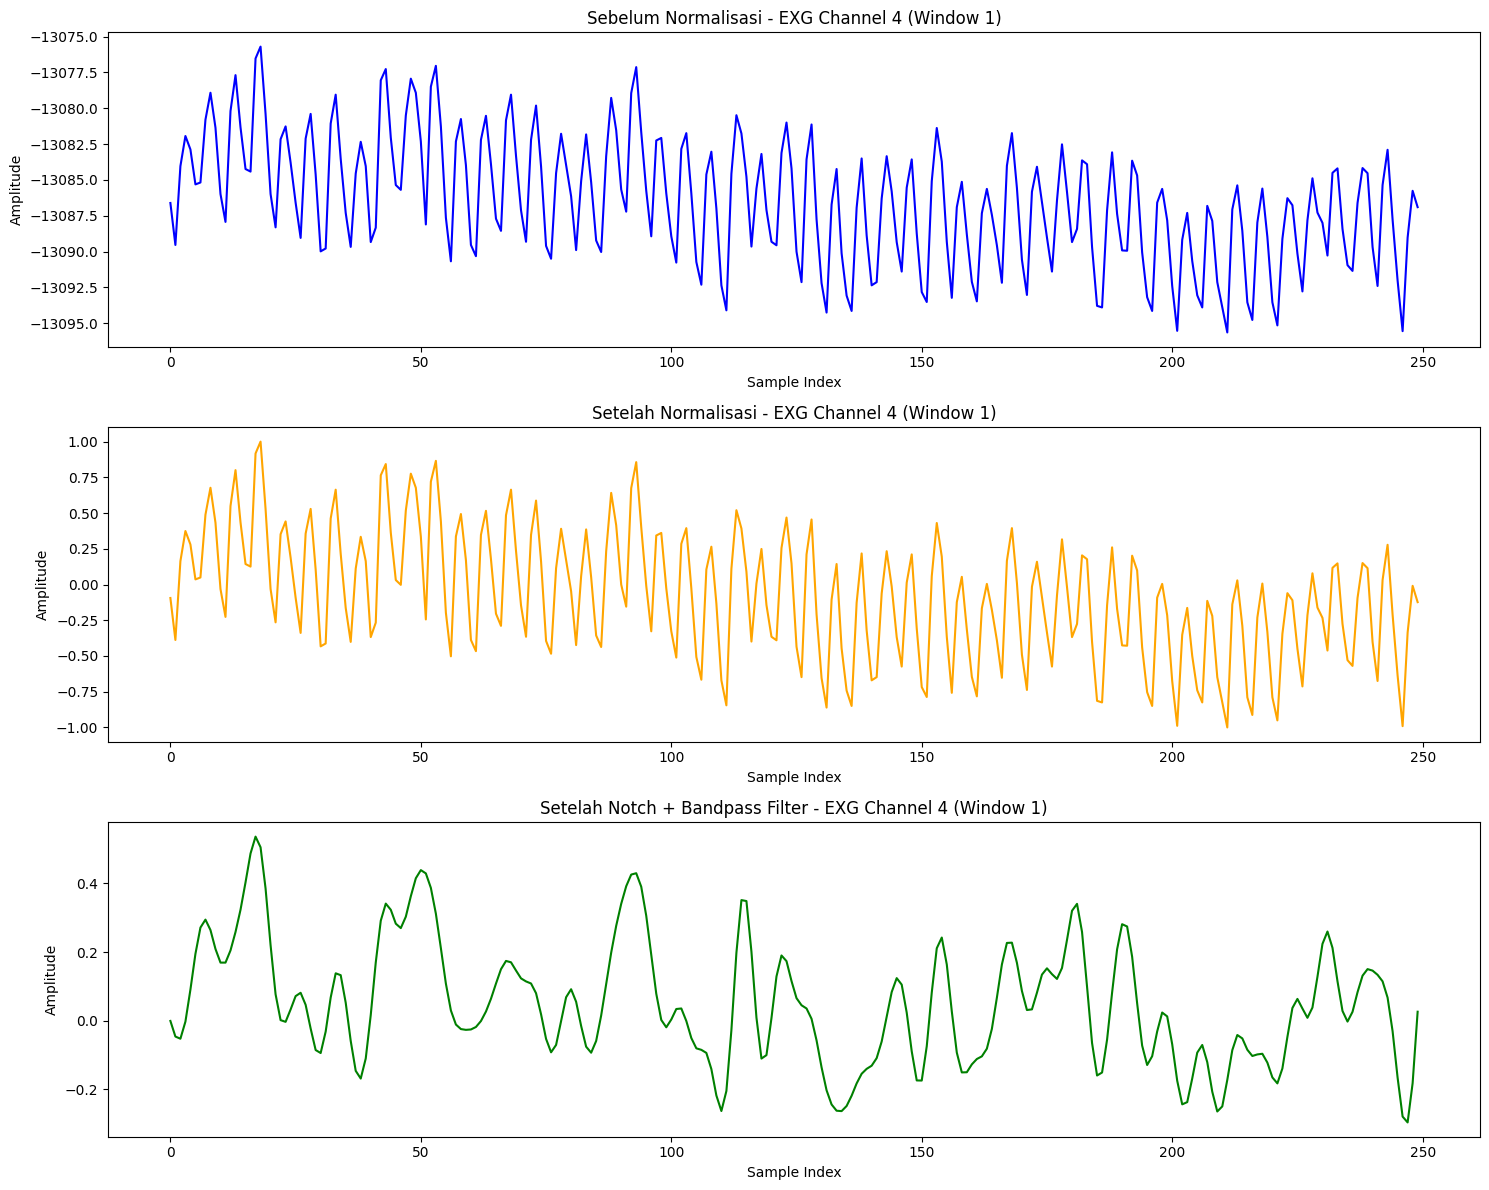

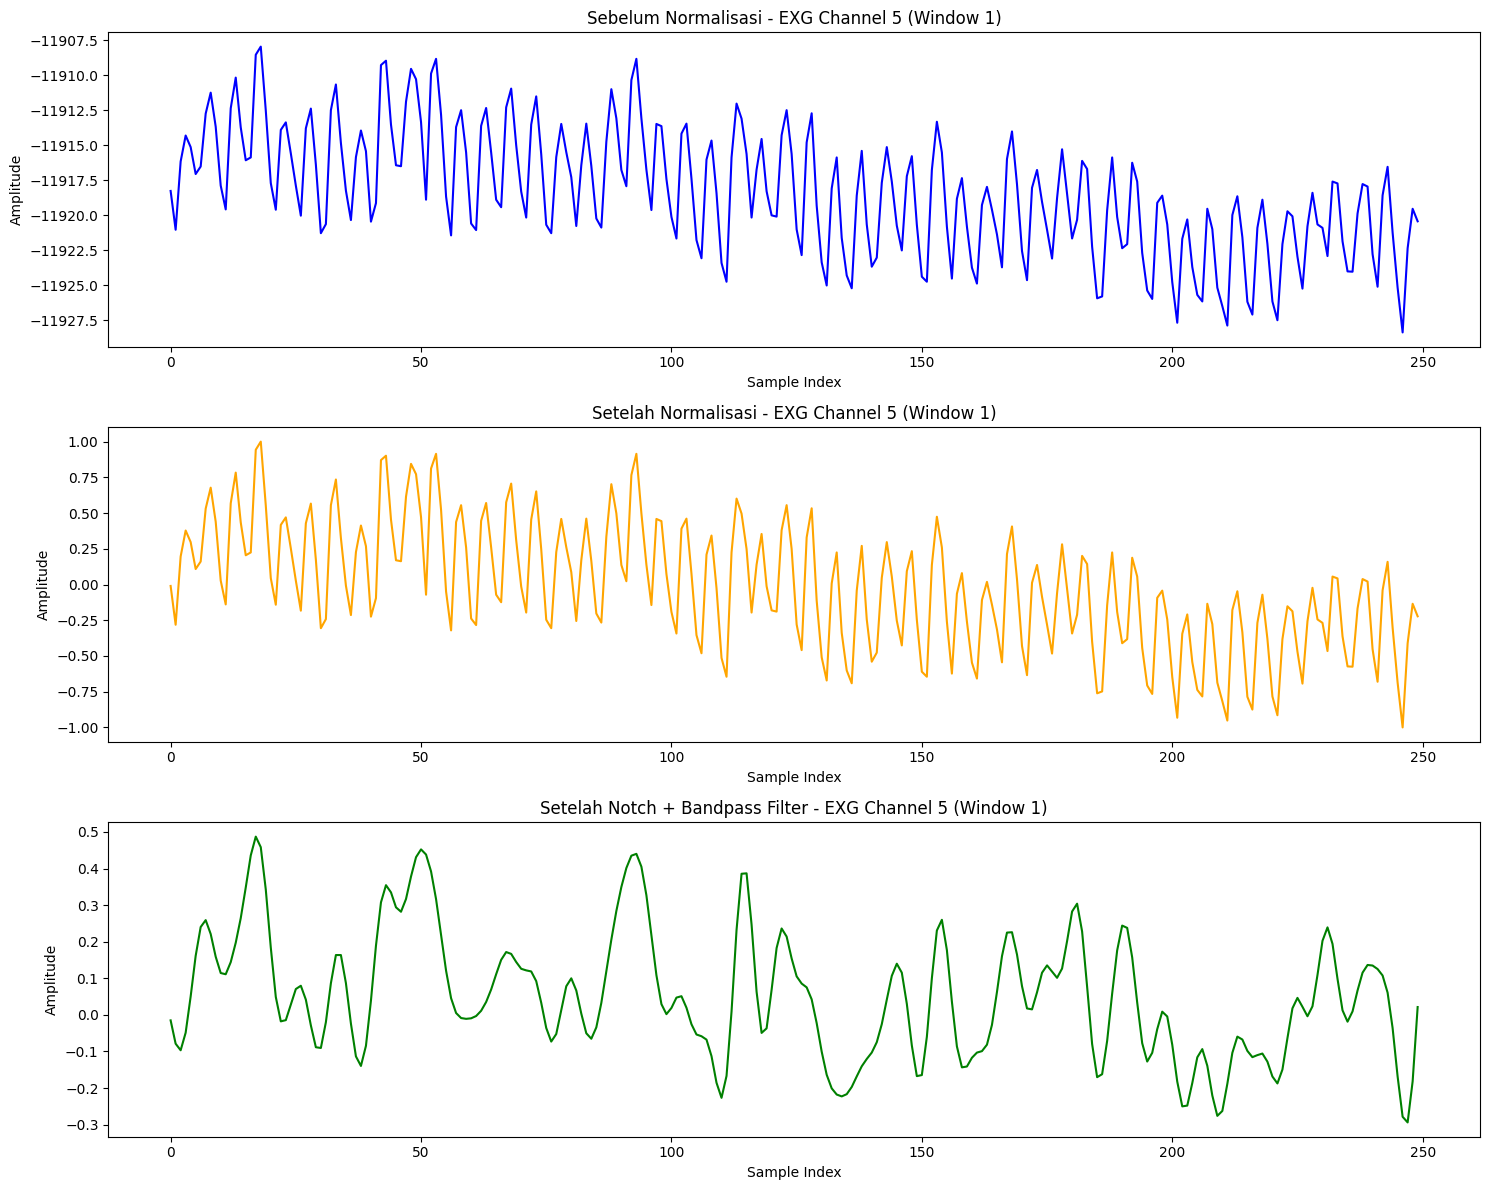

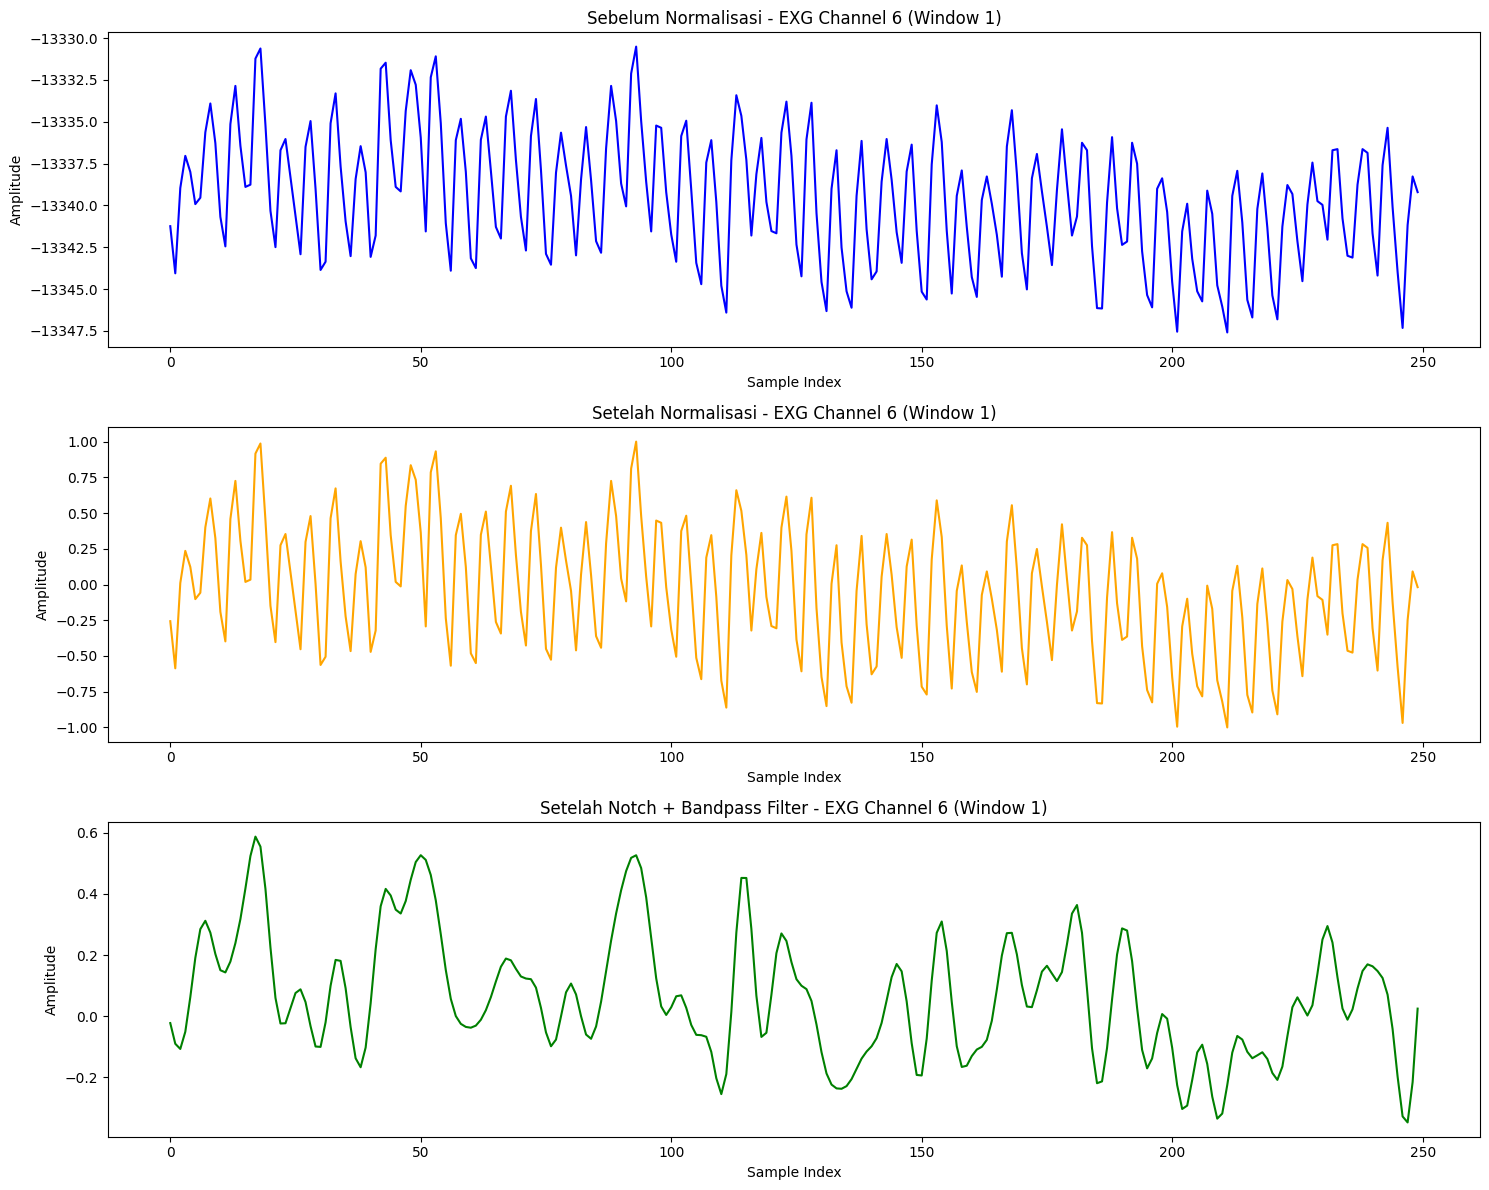

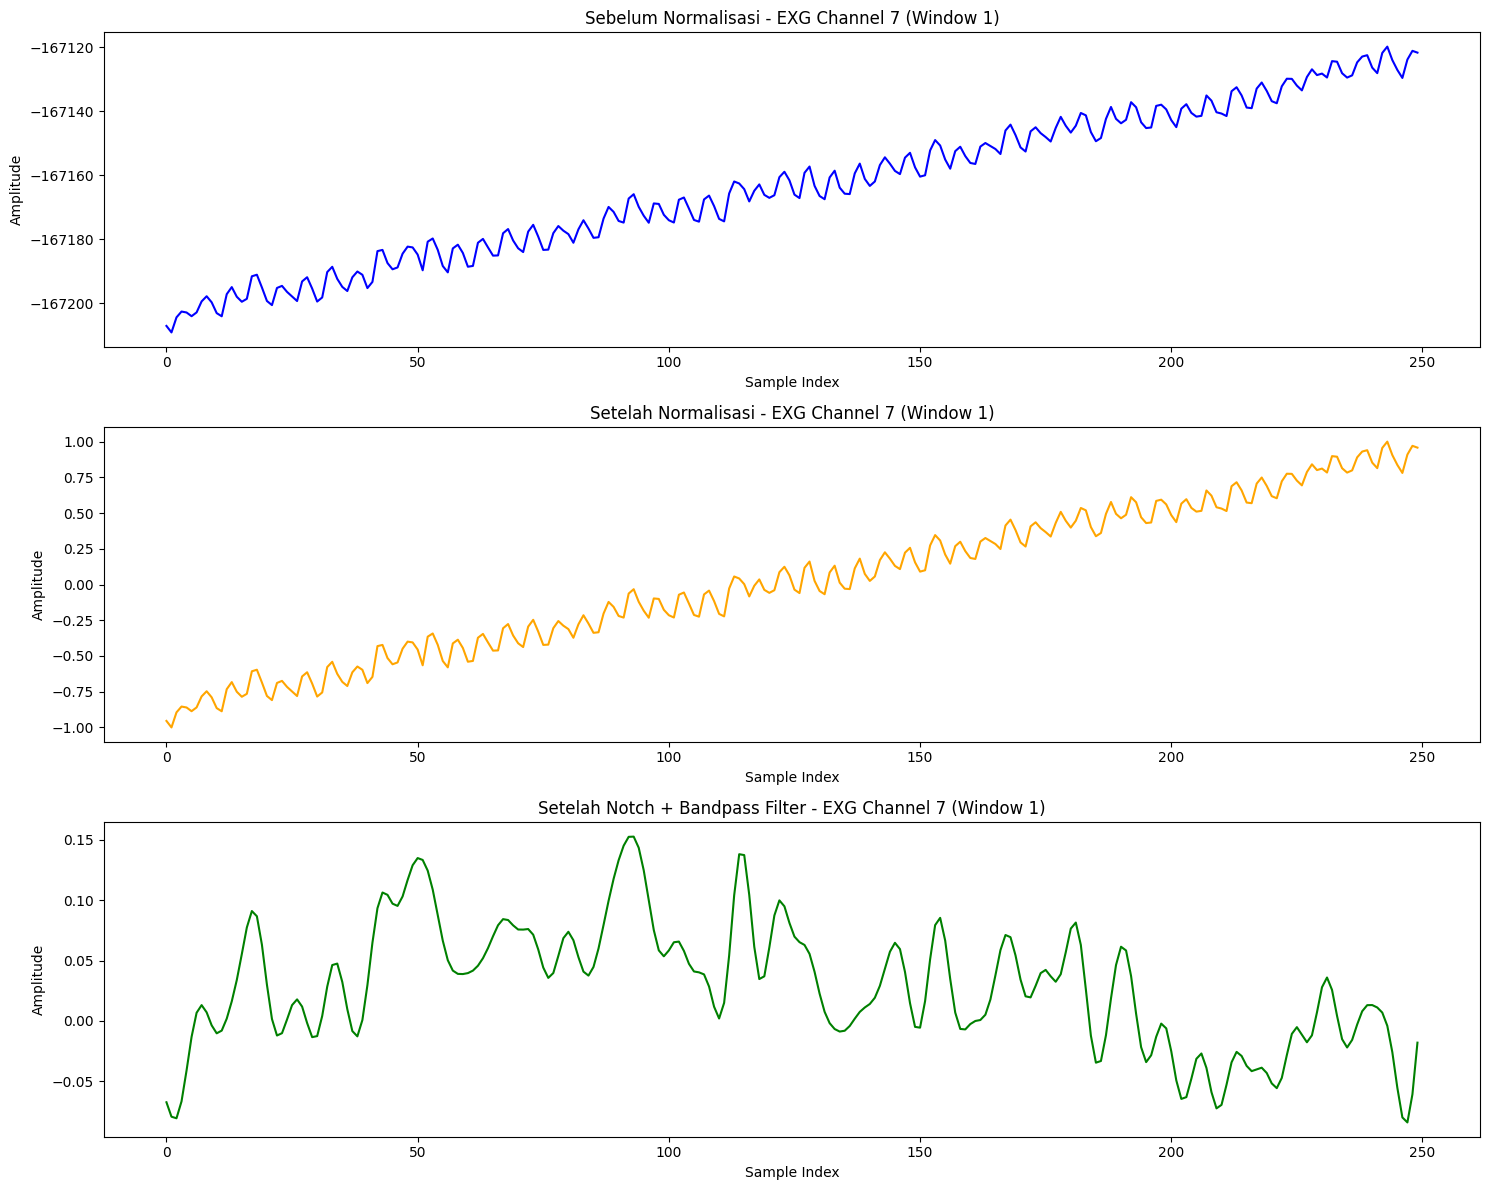

In [68]:
for channel in data.columns[1:9]:  # Loop melalui setiap channel
    plt.figure(figsize=(15, 12))
    
    # Ambil window pertama untuk contoh visualisasi
    window_before = windows_per_channel[channel][0]
    window_normalized = normalized_windows_per_channel[channel][0]
    window_filtered = filtered_windows_per_channel[channel][0]
    
    # Plot sebelum normalisasi
    plt.subplot(3, 1, 1)
    plt.plot(window_before, color='blue')
    plt.title(f"Sebelum Normalisasi - {channel} (Window 1)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    
    # Plot setelah normalisasi
    plt.subplot(3, 1, 2)
    plt.plot(window_normalized, color='orange')
    plt.title(f"Setelah Normalisasi - {channel} (Window 1)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    
    # Plot setelah filtering (notch + bandpass)
    plt.subplot(3, 1, 3)
    plt.plot(window_filtered, color='green')
    plt.title(f"Setelah Notch + Bandpass Filter - {channel} (Window 1)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    
    plt.tight_layout()
    plt.show()

In [71]:
import pandas as pd

# Buat DataFrame untuk menyimpan hasil pemrosesan
processed_data = {}

# Loop melalui setiap channel
for channel in data.columns[1:9]:  # Kolom 1 hingga 8 adalah EXG Channel 0 hingga 7
    # Gabungkan semua window untuk channel ini
    processed_windows = filtered_windows_per_channel[channel]
    
    # Simpan ke DataFrame
    for i, window in enumerate(processed_windows):
        processed_data[f"{channel}_Window_{i + 1}"] = window

# Konversi dictionary ke DataFrame
processed_df = pd.DataFrame(processed_data)

# Simpan ke file CSV
processed_df.to_csv('../data/data_1.csv', index=False)
print("Data berhasil disimpan ke 'processed_eeg_data.csv'")

Data berhasil disimpan ke 'processed_eeg_data.csv'
